### Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (15 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (23 балла)

Дополнительно вы можете получить 5 баллов за оформление работы. Критерии следующие:
- структурированность работы
- наличие и уместность визуализаций
- наличие этапа проверки и предобработки данных и EDA
- использование языка разметки Markdown

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

#### Файлы:

**olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей
    
    customer_id — позаказный идентификатор пользователя

    customer_unique_id —  уникальный идентификатор пользователя  (в идеальных данных не может быть 
    двух пользователей с одинаковым значением, является уникальным айдишником пользователя)

    customer_zip_code_prefix —  почтовый индекс пользователя

    customer_city —  город доставки пользователя

    customer_state —  штат доставки пользователя

**olist_orders_dataset.csv** —  таблица заказов

    order_id —  уникальный идентификатор заказа (номер чека)

    customer_id —  позаказный идентификатор пользователя

    order_status —  статус заказа

    order_purchase_timestamp —  время создания заказа

    order_approved_at —  время подтверждения оплаты заказа

    order_delivered_carrier_date —  время передачи заказа в логистическую службу

    order_delivered_customer_date —  время доставки заказа

    order_estimated_delivery_date —  обещанная дата доставки

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы
    
    order_id —  уникальный идентификатор заказа (номер чека)

    order_item_id —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)

    product_id —  уникальный идентефикатор товара (аналог штрихкода)

    seller_id — уникальный идентефикатор производителя товара

    shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

    price —  цена за единицу товара

    freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

- created — создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
customers = pd.read_csv('/home/vitsli/DataAnalitycs/my_projects/olist_customers_dataset.csv')
orders = pd.read_csv('/home/vitsli/DataAnalitycs/my_projects/olist_orders_dataset.csv')
order_item = pd.read_csv('/home/vitsli/DataAnalitycs/my_projects/olist_order_items_dataset.csv')

Исследуем наши данные

In [3]:
customers.info()
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [5]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

В таблице **customers** отсутствуют пропущенные значения, при этом количество уникальных *customer_id* соответствует количеству строк, а количество *customer_unique_id* отличается более чем на 3 тысячи строк в меньшую сторону. Из этого следует, что некоторым *customer_unique_id* соответствует несколько *customer_id*.

In [6]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [8]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

В таблице **orders** даты указаны в формате object. Переведем их в формат **datetime**. Также отметим, что в колонках *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* присутствуют пропущенные значения.

In [9]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date)
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

In [10]:
order_item.info()
order_item.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
order_item.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Переведем в формат **datetime** колонки датафрейма order_item, соответствующие датам

In [12]:
order_item.shipping_limit_date = pd.to_datetime(order_item.shipping_limit_date)
order_item.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [13]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [14]:
orders.query('order_status == "delivered"')\
    .groupby('customer_id', as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'order_count'})\
    .order_count.value_counts()
    

1    96478
Name: order_count, dtype: int64

In [15]:
order_item[order_item.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


### 1. Найдем количество клиентов, совершивших всего одну покупку

Ранее мы выснили, что у одного уникальногоо покупателя может быть несколько *customer_id*, поэтому нам необходимо добавить в таблицу **orders** уникальные идентификаторы клиентов из **customers**. Используем не inner-джойн,а left-джойн, чтобы гарантированно сохранить все данные левой таблицы.

In [16]:
orders = orders.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

 Статусы:  
    *created* — создан, *approved* — подтверждён, *invoiced* — выставлен счёт, *processing* — в процессе сборки заказа, *shipped* — отгружен со склада, *delivered* — доставлен пользователю, *unavailable* — недоступен, *canceled* — отменён.

In [17]:
orders[(orders.order_approved_at.isna() == True)].order_status.unique()

array(['canceled', 'delivered', 'created'], dtype=object)

In [18]:
orders.query("order_status in ['invoiced', 'approved', 'processing', 'shipped', 'delivered']").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


Теперь найдем всех клиентов, совершивших одну покупку. В качестве условия совершения покупки используем соответствие статуса заказа значениям *invoiced, approved, processing, shipped, delivered*, поскольку все они прошли процедуру подтверждения, а заказы *created* могут быть отменены еще до выставления счета. Аппрув является целевым действием, имеющим свою дату в таблице и подтверждающий намерение клиента совершить покупку.

Сгруппируем данные по *customer_unique_id* и посчитаем количество заказов для каждого пользователя, после чего оставим только тех, у кого количество не превышает единицы.

In [19]:
one_bay_customers = (orders.query("order_status in ['invoiced', 'approved', 'processing', 'shipped', 'delivered']")
        .groupby('customer_unique_id', as_index=False)
        .agg({'order_id': 'count'})
        .rename(columns={'order_id': 'quantity'})
        .query('quantity == 1')
        .quantity.sum()
)
print(f'Количество клиентов, совершивших одну покупку, составляет {one_bay_customers} человек')

Количество клиентов, совершивших одну покупку, составляет 92099 человек


### 2. Выясним, сколько заказов в месяц в среднем не доставляется по разным причинам 

In [20]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Из имеющихся в данных статусов под категорию недоставленные попадают отмененные(canceled) и недоступные(unavailable), остальные находятся либо в процессе оформления, либо в доставке, либо доставлены.

In [21]:
orders['purchase_month'] = orders.order_purchase_timestamp.dt.to_period('M')

In [22]:
orders.query("order_status in ['canceled', 'unavailable']")\
        .groupby(['purchase_month', 'order_status'], as_index=False)\
        .agg({'order_id':'count'})\
        .pivot_table(index='purchase_month', columns='order_status', values='order_id')\
        .mean().round(2)

order_status
canceled       26.04
unavailable    29.00
dtype: float64

В среднем ежемесячно не доставляется 55 заказов, из них - 26 из-за отмены, а 29 из-за недоступности товаров

### 3. Для каждого товара определим, в какой день недели товар чаще всего покупается

Для выполнения данного задания нам необходимо смерджить таблицы *orders* и *order_item*, после чего добавить столбец, в котором будет проставлен день недели для каждого товара. В данном случае в качестве даты возьмем *order_purchase_timestamp*, поскольку нас интересует не подтверждение заказа, а сам выбор товара клиентом в конкретный день.

In [23]:
order_merge = order_item.merge(orders, how='left', on='order_id')

In [24]:
order_merge

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,0c9aeda10a71f369396d0c04dce13a64,2018-04
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,0da9fe112eae0c74d3ba1fe16de0988b,2018-07
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,cd79b407828f02fdbba457111c38e4c4,2017-10
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,eb803377c9315b564bdedad672039306,2017-08


In [25]:
order_merge['order_weekday'] = order_merge['order_purchase_timestamp'].apply(lambda x: x.strftime("%A"))

Сгруппируем данные по *product_id* и *order_weekday* и посчитаем количество заказов

In [26]:
max_weekday_bays = order_merge.groupby(['product_id', 'order_weekday'], as_index=False)\
        .agg({'order_id': 'count'})\
        .rename(columns={'order_id': 'amount'})\
        .sort_values('amount', ascending=False)
       
max_weekday_bays.head(10)

,product_id,order_weekday,amount
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41041,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41046,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
15900,422879e10f46682990de24d770e7f83d,Thursday,79
41042,aca2eb7d00ea1a7b8ebd4e68314663af,Monday,78
15896,422879e10f46682990de24d770e7f83d,Friday,77
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
36512,99a4788cb24856965c36a24e339b6058,Friday,75


Отберем в список индексы с максимальным количеством покупок для каждого товара

In [27]:
index_ls = max_weekday_bays.groupby('product_id').amount.idxmax()
index_ls

product_id
00066f42aeeb9f3007548bb9d3f33c38        0
00088930e925c41fd95ebfe695fd2655        1
0009406fd7479715e4bef61dd91f2462        2
000b8f95fcb9e0096488278317764d19        3
000d9be29b5207b54e86aa1b1ac54872        5
                                    ...  
fff6177642830a9a94a0f2cba5e476d1    61222
fff81cc3158d2725c0655ab9ba0f712c    61223
fff9553ac224cec9d15d49f5a263411f    61224
fffdb2d0ec8d6a61f0a0a0db3f25b441    61228
fffe9eeff12fcbd74a2f2b007dde0c58    61229
Name: amount, Length: 32951, dtype: int64

Выберем из датафрейма по индексам интересующие нас покупки дням недели. С помощью query можем фильтровать нижний порог количества продаж.

In [28]:
max_weekday_bays[max_weekday_bays.index.isin(index_ls)].query('amount > 3').head(10)

,product_id,order_weekday,amount
15902,422879e10f46682990de24d770e7f83d,Wednesday,93
36513,99a4788cb24856965c36a24e339b6058,Monday,92
41045,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20127,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13537,389d119b48cf3043d311335e499d9c6b,Thursday,67
12998,368c6c730842d78016ad823897a372db,Friday,67
20078,53759a2ecddad2bb87a079a1f1519f73,Wednesday,66
50199,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,64
14834,3dd2a17168ec895c781a9191c1e95ad7,Wednesday,54
39518,a62e25e09e05e6faf31d90c6ec1aa3d1,Thursday,50


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.  

Создадим клон таблицы *orders*, в который добавим для каждого заказа месяц из даты *order_purchase_timestamp*

In [31]:
orders_temp = orders.copy()

In [32]:
orders_temp['purchase_month'] = orders['order_purchase_timestamp'].astype('datetime64[M]')
orders_temp.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-01


Для дальнейшей работы сгруппируем данные по *customer_unique_id* и *purchase_month*, посчитаем для каждого пользователя количество заказов в разбивке по месяцам. Предварительно отфильтруем из данных строки, с пропущенными значениями для *order_approved_at* (в первом задании мы уже определились что будем считать совершенными покупками)

In [77]:
weekly_orders = (
                 orders_temp[orders_temp.order_approved_at.isna() == False]
                 .groupby(['customer_unique_id', 'purchase_month'], as_index=False).agg({'order_id':'count'})
                )
weekly_orders.head()

,customer_unique_id,purchase_month,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1


Теперь, чтобы получить для каждого пользователя количество покупок в среднем в неделю по месяцам, нам нужно разделить количество покупок в месяц на число недель в конкретный месяц. Для этого нам нужно рассчитать соответствующие коэффициенты для каждого из месяцев, учитывая,количество дней в каждом из них. Так для месяцев с 31 днем коэффициент будет равен 4.43 (округляем до второго знака), для 30 - 4.29, для 28 - 4. Также стоит учесть, что первый и последний месяцы в таблице не полные, для них рассчитаем коэффициенты отдельно. Для сентября 2016 года это будет 3.86, а для октября 2018-го - 2.43. Напишем функцию рассчета.

In [78]:
def w_coeff(x):
    if x.strftime('%Y-%m-%d') == '2016-09-01':
        return 3.86
    
    elif x.strftime('%Y-%m-%d') == '2018-10-01':
        return 2.43
    
    elif x.strftime('%m-%d') in [
                               '01-01', 
                               '03-01',
                               '05-01',
                               '07-01',
                               '08-01',
                               '10-01',
                               '12-01'
                               ]:
        return 4.43
    
    elif x.strftime('%m-%d') in [
                               '04-01', 
                               '06-01',
                               '09-01',
                               '11-01',
                                ]:
        return 4.29
    
    else:
        return 4


Добавим столбец с коэффициентами и рассчитаем среднее количество продаж в неделю по месяцам

In [79]:
weekly_orders['coeff'] = weekly_orders.purchase_month.apply(w_coeff)

In [80]:
weekly_orders['week_mean_purchase'] = round(weekly_orders.order_id / weekly_orders.coeff, 2)

In [81]:
weekly_orders.sort_values('week_mean_purchase', ascending=False)

,customer_unique_id,purchase_month,order_id,coeff,week_mean_purchase
7315,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.43,1.35
23911,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,4.00,1.00
69304,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,4,4.00,1.00
62116,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,4.00,1.00
67667,b08fab27d47a1eb6deda07bfd965ad43,2017-09-01,4,4.29,0.93
...,...,...,...,...,...
34240,592aba1d8e1d592fc9be07cfa685e88f,2017-06-01,1,4.29,0.23
34239,59299ea0e75eec7b97507e1dc6ac13d1,2017-01-01,1,4.43,0.23
34238,59293545b02da9dd4e3e704c7e73f0d6,2017-11-01,1,4.29,0.23
34237,592891bfd137d0161b5209a387a4e9cb,2017-03-01,1,4.43,0.23


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

Нас интересует период с 2017-01-01 по 2017-12-31 - только он подходит по условию задания, поскольку, в таблице у нас присутствуют данные с 2016-09-04 по 2018-10-17 (лишь один полный год с января по декабрь)

In [367]:
min_date = pd.to_datetime('2017-01-01')
max_date = pd.to_datetime('2017-12-31')

Создадим себе клон *orders* для дальнейшей работы, а также вспомогательный датафрейм *period*, в котором зададим календарь на 2017 год по месяцам. Впоследствии мы его приджойним к таблице заказов

In [368]:
orders_rn = orders.copy()

In [369]:
period = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS'))
period = period.rename(columns={0:'purchase_month'})
period

,purchase_month
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01
5,2017-06-01
6,2017-07-01
7,2017-08-01
8,2017-09-01
9,2017-10-01


Поскольку у нас нет дат регистрации пользователя, для точки отсчета будем использовать даты первого заказа для каждого уникального пользователя. Отберем соответствующие поля в отдельный датафрейм. Для порядка создадим отдельное поле, в котором сохраним дату первой покупки, приведенную к началу месяца. Это поле будет точкой отсчета для ретеншена.

In [371]:
customers_activity = orders.groupby('customer_unique_id', as_index=False).order_purchase_timestamp.min()
customers_activity.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [372]:
customers_activity['order_purchase_month'] = customers_activity['order_purchase_timestamp'].astype('datetime64[M]')
customers_activity = customers_activity.rename(columns={'order_purchase_month': 'first_purchase'})
customers_activity = customers_activity.drop(columns='order_purchase_timestamp')

In [374]:
customers_activity.head()

,customer_unique_id,first_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01


Смерджим таблицы **customers_activity** и **period** кроссджойном, создав для этого вспомогательные ключи. Таким образом мы получим заготовку, в которой каждому пользователю будут соответствовать поля с каждым из 12 месяцев года. Размер таблицы можно укоротить, исключив из него для каждого пользователя месяца года, которые меньше, чем месяц его первого заказа.

In [376]:
customers_activity['key'] = 1

In [377]:
period['key'] = 1

In [378]:
template = customers_activity.merge(period, on='key')[['customer_unique_id', 'first_purchase', 'purchase_month']]
template

,customer_unique_id,first_purchase,purchase_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-01-01
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-02-01
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-03-01
3,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-04-01
4,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2017-05-01
...,...,...,...
1153147,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01
1153148,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01
1153149,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01
1153150,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01


In [387]:
template = template[template.purchase_month >= template.first_purchase]
template

,customer_unique_id,first_purchase,purchase_month
26,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01
27,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01
28,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01
29,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01
30,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01
...,...,...,...
1153147,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01
1153148,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01
1153149,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01
1153150,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01


В наш клоне **orders** добавим столбец, в котором будет указан месяц для каждого заказа. После этого отберем из таблицы уникальных пользователей с *order_id* и покупками по месяцам и сохраним во вспомогательный датафрейм

In [389]:
orders_rn['purchase_month'] = orders_rn['order_purchase_timestamp'].astype('datetime64[M]')
orders_rn.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-01


In [390]:
purchase = (
            orders_rn[(orders_rn['order_purchase_timestamp'] > min_date) 
                      & (orders_rn['order_purchase_timestamp'] < max_date)]
                    [['customer_unique_id', 'purchase_month', 'order_id']]
            ).copy()
purchase

,customer_unique_id,purchase_month,order_id
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-01,e481f51cbdc54678b7cc49136f2d6af7
3,7c142cf63193a1473d2e66489a9ae977,2017-11-01,949d5b44dbf5de918fe9c16f97b45f8a
5,80bb27c7c16e8f973207a5086ab329e2,2017-07-01,a4591c265e18cb1dcee52889e2d8acc3
6,36edbb3fb164b1f16485364b6fb04c73,2017-04-01,136cce7faa42fdb2cefd53fdc79a6098
7,932afa1e708222e5821dac9cd5db4cae,2017-05-01,6514b8ad8028c9f2cc2374ded245783f
...,...,...,...
99433,c716cf2b5b86fb24257cffe9e7969df8,2017-10-01,9115830be804184b91f5c00f6f49f92d
99434,e03dbdf5e56c96b106d8115ac336f47f,2017-01-01,aa04ef5214580b06b10e2a378300db44
99435,831ce3f1bacbd424fc4e38fbd4d66d29,2017-02-01,880675dff2150932f1601e1c07eadeeb
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-01,9c5dedf39a927c1b2549525ed64a053c


Смерджим **report** c **purchase** по полям *customer_unique_id* и *purchase_month* left-джойном, чтобы поля, для которых не существует *order_id* заполнились значениями NaN.

In [391]:
report = template.merge(purchase, how='left', on=['customer_unique_id', 'purchase_month'])
report

,customer_unique_id,first_purchase,purchase_month,order_id
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,b33ec3b699337181488304f362a6b734
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN
...,...,...,...,...
225688,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-08-01,NaN
225689,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-09-01,NaN
225690,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-10-01,NaN
225691,ffffd2657e2aad2907e67c3e9daecbeb,2017-05-01,2017-11-01,NaN


Добавим в таблицу поле *activity* (1 - ознаяает активность клиента, 0 - отсутствие активности), которое нам понадобится при создании сводной таблицы. Также создадим поле *livetime*, в котором для каждого пользователя будет указано количество месяцев с момента его первого заказа

In [395]:
report['activity'] = (report['order_id'].isna() == False) * 1

In [396]:
report['livetime'] = ((report['purchase_month'] - report['first_purchase'])/ np.timedelta64(1, 'M')).round().astype(int)

In [397]:
report.head()

,customer_unique_id,first_purchase,purchase_month,order_id,activity,livetime
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,b33ec3b699337181488304f362a6b734,1,0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN,0,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN,0,2
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN,0,3
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN,0,4


Создадим сводную таблицу для ретеншена, где в индексы пойдут месяца первой покупки, в названия колонок значения  livetime, а в сами значения полей - данные из activity. Агрегировать будем с помощью mean, который в итоге выдаст нам активность когорт по долям. Для отбора данных зададим нижнюю границу для *first_purchase* большую или равную 2017-01-01. Верхняя граница в была нами учтена ранее.

In [398]:
retention = (report[report['first_purchase'] >= '2017-01-01']
        .pivot_table(index='first_purchase', columns='livetime', values='activity', aggfunc='mean')
            )
retention.head()

livetime,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase,,,,,,,,,,,,
2017-01-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.000000,0.003927,0.001309
2017-02-01,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,NaN
2017-03-01,1.0,0.005309,0.003794,0.004549,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,NaN,NaN
2017-04-01,1.0,0.006375,0.002550,0.002125,0.003401,0.002551,0.003825,0.002976,0.002976,NaN,NaN,NaN
2017-05-01,1.0,0.005282,0.005835,0.003893,0.003059,0.003891,0.004725,0.001669,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='livetime', ylabel='first_purchase'>

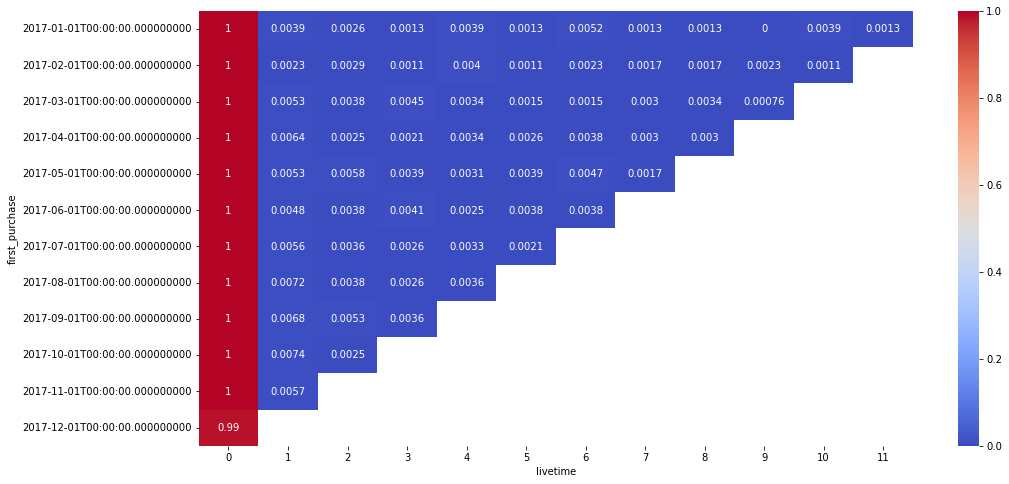

In [406]:
plt.figure(figsize=(16,8))
sns.heatmap(retention, annot = True, cmap= 'coolwarm')

Поскольку heatmap нам особо много не дал, найдем интересующую нас когорту руками

In [400]:
retention.reset_index()

livetime,first_purchase,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-01-01,1.000000,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,0.000000,0.003927,0.001309
1,2017-02-01,1.000000,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,NaN
2,2017-03-01,1.000000,0.005309,0.003794,0.004549,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,NaN,NaN
3,2017-04-01,1.000000,0.006375,0.002550,0.002125,0.003401,0.002551,0.003825,0.002976,0.002976,NaN,NaN,NaN
4,2017-05-01,1.000000,0.005282,0.005835,0.003893,0.003059,0.003891,0.004725,0.001669,NaN,NaN,NaN,NaN
5,2017-06-01,1.000000,0.004779,0.003822,0.004141,0.002549,0.003823,0.003823,NaN,NaN,NaN,NaN,NaN
6,2017-07-01,1.000000,0.005647,0.003595,0.002568,0.003337,0.002054,NaN,NaN,NaN,NaN,NaN,NaN
7,2017-08-01,1.000000,0.007168,0.003822,0.002629,0.003585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017-09-01,1.000000,0.006780,0.005327,0.003628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2017-10-01,1.000000,0.007379,0.002461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
retention[2].idxmax()

Timestamp('2017-05-01 00:00:00')

Когорте с наибольшим ретеншеном на третий месяц соответствует май 2017 года

### 6. RFM

Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров

Для создания RFM в основной таблице нам не хватает денежных трат по каждому пользователю. Из датафрейма order_item, отберем данные по тратам, сгруппировав их по *order_id*. После этого примерджим полученные данные к orders с использованием left-джойна. Для рассчета будем использовать даты подтвержденных заказов. 

In [409]:
prices = (order_item.groupby('order_id', as_index=False)
                        .agg({'price': 'sum'})
                )

In [410]:
orders_price = orders.merge(prices, how='left', on='order_id')

In [412]:
# запишем в переменную максимальную дату заапрувленного заказа, позже она нам пригодится
max_approved_date = orders_price.order_approved_at.max()

В полученном датафрейме исключим строки, у которых в *order_approved_at* имеются пропущенные значения, поскольку они соотвествуют неподтвержденным заказам.  

In [413]:
orders_price = orders_price[orders_price.order_approved_at.isna() == False]

Создадим заготовку для нашего RFM-скора. Сгруппируем данные по *customer_unique_id*, после чего проведем агргрегацию: для *order_approved_at* отберем максимальные значения (будут соответствовать последней активности клиента, для *price* посчитаем сумму (фактически это будет наше **monetary**), для *order_id* посчитаем  количество (это наша **frequency**)) 

In [414]:
rfm_score = (orders_price.groupby('customer_unique_id', as_index=False).
            agg({
                'order_approved_at':'max',
                'price':'sum',
                'order_id':'count'
                }
                 )
            )

In [418]:
rfm_score = rfm_score.rename(columns={
                                    'order_approved_at':'last_purchase',
                                    'price':'monetary',
                                    'order_id':'frequency'  
                                    }
                            )
rfm_score.head()

,customer_unique_id,last_purchase,monetary,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,1


Для составления RFM нам не хватает только recency, который мы легко можем получить в результате вычетания из ранее посчитанной *max_approved_date* даты последней активности пользователя. 

In [419]:
rfm_score['recency'] = (max_approved_date - rfm_score['last_purchase']).dt.days

In [421]:
rfm_score.head()

,customer_unique_id,last_purchase,monetary,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,1,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,1,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,1,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,1,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,1,292


Для составления RFM попробуем воспользоваться функцией Pandas qcut, которая делит выборку по квантилям. Делить будем на пять отрезков. Без использования аргумента labels, функция присваивает просто порядковый номер  по разбиению на отрезки. С использованием данного аргумента указываются границы для каждого из отрезков. В поле r у нас будет значение от 1 до 5, а в r_interval границы интервалов.

In [422]:
rfm_score['r'] = 5 - (pd.qcut(rfm_score.recency, 5, labels=False)) 

In [423]:
rfm_score['r_interval'] = (pd.qcut(rfm_score.recency, 5))

In [425]:
rfm_score.head()

,customer_unique_id,last_purchase,monetary,frequency,recency,r,r_interval
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,1,116,4,"(97.0, 182.0]"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,1,118,4,"(97.0, 182.0]"
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,1,541,1,"(388.0, 718.0]"
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,1,325,2,"(273.0, 388.0]"
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,1,292,2,"(273.0, 388.0]"


Проверим, как функция разбила наше множество значений recency

In [426]:
rfm_score.groupby('r').recency.agg(['mean', 'count'])

,mean,count
r,,
1,479.526017,19180
2,321.989939,19084
3,225.758515,19260
4,140.551187,19253
5,49.690479,19220


Получилось довольно равномерное разбиение по количеству значений в каждом отрезке. Для frequency вероятно использовать данный метод будет нельзя, поскольку в данном столбце присутствует большое количество одинаковых значений с огромным перевесом для 1. функция qcut в данном случае сработает плохо.

In [427]:
rfm_score.frequency.value_counts()

1     93049
2      2708
3       191
4        30
5         8
6         6
7         3
9         1
17        1
Name: frequency, dtype: int64

Напишем небольшие функции для разбивки f и f_interval

In [428]:
def f_count(x):
    if x == 1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
    else:
        return 5

In [430]:
rfm_score['f'] = rfm_score.frequency.apply(f_count)

In [431]:
def f_interval(x):
    if x == 1:
        return 1
    elif x==2:
        return 2
    elif x==3:
        return 3
    elif x==4:
        return 4
    else:
        return '> 4'

In [432]:
rfm_score ['f_interval'] = rfm_score.frequency.apply(f_interval)

Для разбивки monetary также используем qcut

In [433]:
rfm_score['m'] = (pd.qcut(rfm_score.monetary, 5, labels=False) + 1) 

In [434]:
rfm_score['m_interval'] = (pd.qcut(rfm_score.monetary, 5)) 

Проверим, как выглядит наша разбивка

In [436]:
rfm_score.groupby('m').monetary.agg(['mean', 'count'])

,mean,count
m,,
1,24.485861,19207
2,52.981822,19246
3,88.396323,19463
4,140.433875,19050
5,404.826980,19031


Наконец рассчитаем наш RFM-score

In [440]:
rfm_score['rfm'] = rfm_score.r + rfm_score.f + rfm_score.m

In [441]:
rfm_score.head()

,customer_unique_id,last_purchase,monetary,frequency,recency,r,r_interval,f,f_interval,m,m_interval,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,129.90,1,116,4,"(97.0, 182.0]",1,1,4,"(109.9, 179.9]",9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,18.90,1,118,4,"(97.0, 182.0]",1,1,1,"(-0.001, 39.0]",6
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,69.00,1,541,1,"(388.0, 718.0]",1,1,2,"(39.0, 69.0]",4
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,25.99,1,325,2,"(273.0, 388.0]",1,1,1,"(-0.001, 39.0]",4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,180.00,1,292,2,"(273.0, 388.0]",1,1,5,"(179.9, 13440.0]",8
